# Glioma Grading Clinical and Mutation Features

In [1]:
from pathlib import Path

import pandas as pd

from src.data_processing import convert_age, normalize_dataset
from src.encoders import encode_dataset, onehot_encode_dataset, label_encode_dataset
from src.feature_estimators import get_feature_estimator, select_by_correlation_value, concat_important_features
from src.visualize import make_2d_representation

# Data processing
---

In [2]:
DATASETS_PATH = Path('datasets')
train_dataset_path = DATASETS_PATH / 'train.csv'
test_dataset_path = DATASETS_PATH / 'test.csv'

In [3]:
data = pd.read_csv(train_dataset_path, index_col=0)
data.head()

,Grade,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,PTEN,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,GBM,TCGA-06-A6S0,Male,79 years 183 days,Glioblastoma,black or african american,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-HT-8106,Male,53 years 197 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
2,LGG,TCGA-HT-7607,Female,61 years 305 days,"Astrocytoma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-QH-A6X5,Female,58 years 55 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
4,LGG,TCGA-P5-A5F1,Male,30 years 113 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


### Column Analysis

* The `Grade` column is our target.

* The column `Primary_Diagnosis` has 5 unique values, we will encode it with `LabelEncoder`.

* Column `Case_ID` represents unique id of case, we will remove from our dataset.

* The following columns represent the gen mutations.
    ```text
    IDH1, TP53, ATRX, PTEN, EGFR, CIC, MUC16, PIK3CA,
    NF1, PIK3R1, FUBP1, RB1, NOTCH1, BCOR, CSMD3, SMARCA4,
    GRIN2A, IDH2, FAT4, PDGFRA
    ```
    They might be only `MUTATED` or `NOT_MUTATED`, so we will encode it with `LabelEncoder`.

* The binary type column `Gender` will be encoded with `LabelEncoder` too.

* The `Age_at_diagnosis` column has a string representation of date. We will convert it into the numeric type.

### Missing Data

We detect that 4 cases has no `Age_at_diagnosis` data. We decided to remove them from training set.

In [4]:
data_processing = data.copy().drop(['Case_ID'], axis=1)


data_processing['Age_at_diagnosis'] = convert_age(data_processing['Age_at_diagnosis'])
data_processing.dropna(axis=0, inplace=True)

data_processing = encode_dataset(data_processing, encoder='OneHot', target='Grade')

2d Representation of our data is presented at the figure below

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

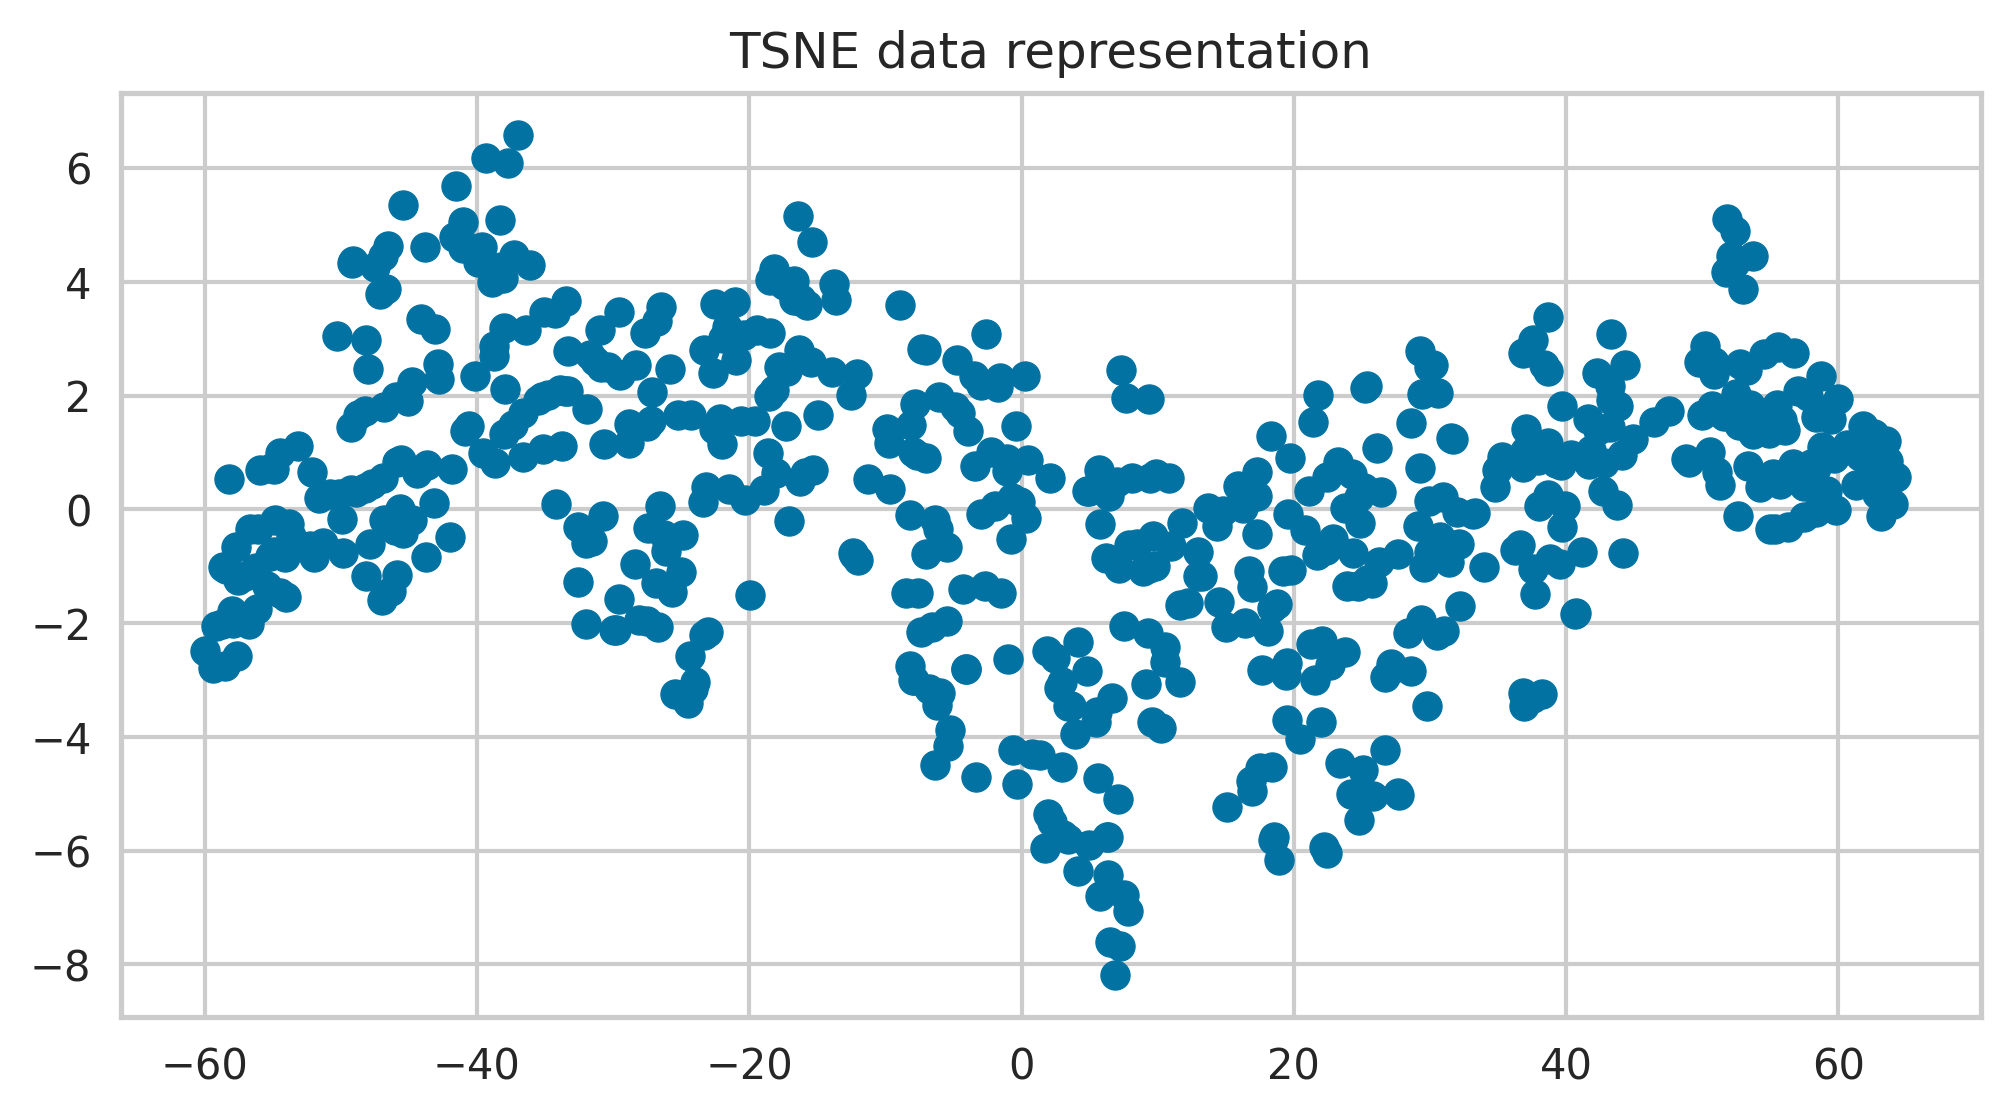

In [5]:
figure = make_2d_representation(data_processing)

## Feature selection
---

To investigate the most valuable features we decided to calculate some correlation metrics.

In [6]:
data_for_feature_analysis = data_processing.copy()
training_data = normalize_dataset(data_for_feature_analysis.drop(['Grade'], axis=1))
targets = data_for_feature_analysis['Grade']

### Mutual information
Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.


{'Primary_Diagnosis_Glioblastoma': 0.6813527550864881,
 'IDH1_MUTATED': 0.30474698301683545,
 'IDH1_NOT_MUTATED': 0.28915414220044755}

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

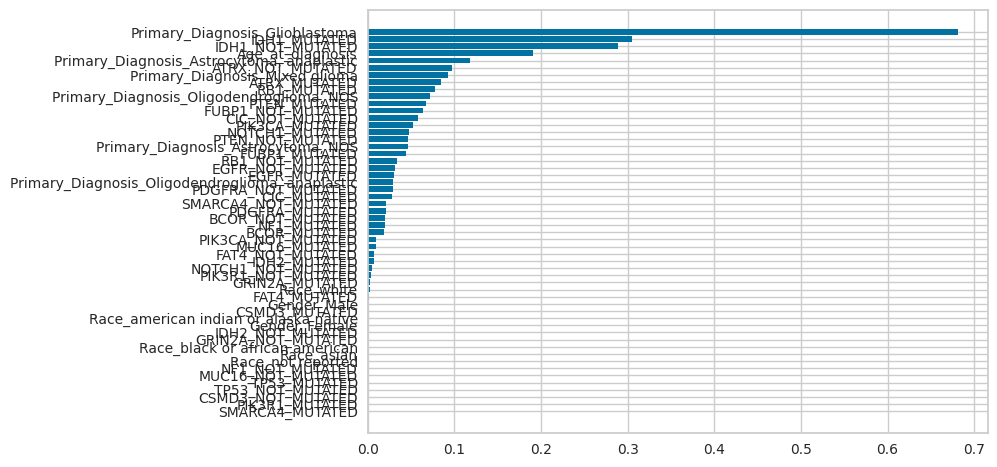

In [7]:
correlation_estimator = get_feature_estimator(training_data, targets, method='mutual_info-classification')
mutual_important_values = select_by_correlation_value(correlation_estimator, min_score=0.2)
mutual_important_values

The most valuable features are:
```text
Primary_Diagnosis, IDH1, Age_at_diagnosis
```

The least valuable features are:
```text
Gender, BCOR, FAT4, PIK3CA, Race, GRIN2A, PIK3R1
```

### Pearson's 

The Pearson correlation measures the strength of the linear relationship between two variables.

{'IDH1_MUTATED': 0.7184064988134623,
 'PTEN_NOT_MUTATED': 0.38394516594881567,
 'Primary_Diagnosis_Mixed glioma': 0.3699832537685512,
 'Primary_Diagnosis_Astrocytoma, anaplastic': 0.3465480315731736,
 'ATRX_MUTATED': 0.3394964235479059,
 'Primary_Diagnosis_Oligodendroglioma, NOS': 0.31747102266467214,
 'CIC_MUTATED': 0.30475437852430887,
 'Primary_Diagnosis_Oligodendroglioma, anaplastic': 0.25436199833816603,
 'Primary_Diagnosis_Astrocytoma, NOS': 0.2428772894910035,
 'EGFR_NOT_MUTATED': 0.23206341419732127,
 'RB1_NOT_MUTATED': 0.22234650446066653,
 'RB1_MUTATED': -0.22234650446066653,
 'EGFR_MUTATED': -0.23206341419732127,
 'CIC_NOT_MUTATED': -0.30475437852430887,
 'ATRX_NOT_MUTATED': -0.3394964235479059,
 'PTEN_MUTATED': -0.38394516594881567,
 'Age_at_diagnosis': -0.5287350927689344,
 'IDH1_NOT_MUTATED': -0.7184064988134623,
 'Primary_Diagnosis_Glioblastoma': -0.9999999999999998}

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

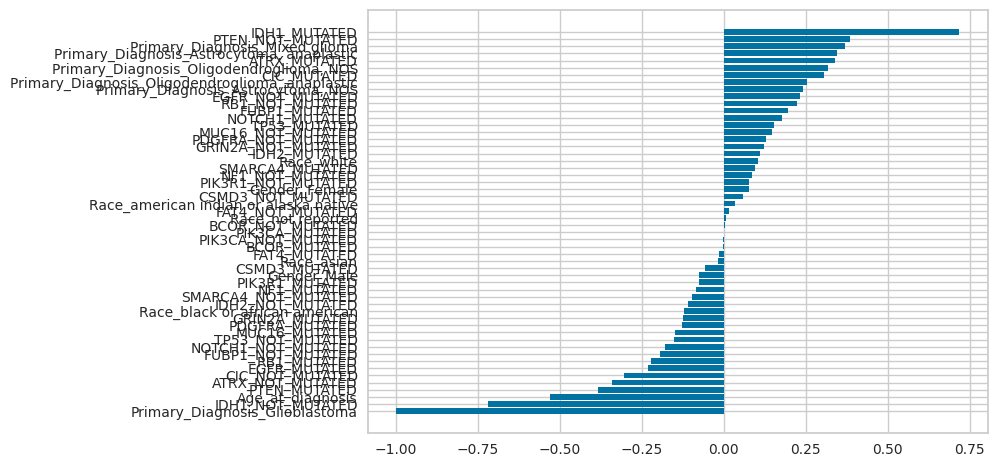

In [8]:
correlation_estimator = get_feature_estimator(training_data, targets, method='pearson')
pearson_important_values = select_by_correlation_value(correlation_estimator, min_score=0.2)
pearson_important_values

The most valuable features are
```text
IDH1, Age_at_diagnosis, PTEN, ATRX, CIC
```

The least valuable features are:
```text
BKOR, PIK3CA, FAT4
```

### Selected Features

We decided to automatically select features if their correlation metric is greater than 0.2

In [9]:
keep_columns = concat_important_features(pearson_important_values, mutual_important_values)
training_data = training_data[keep_columns]
training_data

,Primary_Diagnosis_Mixed glioma,Age_at_diagnosis,IDH1_NOT_MUTATED,"Primary_Diagnosis_Oligodendroglioma, anaplastic",RB1_MUTATED,EGFR_MUTATED,"Primary_Diagnosis_Oligodendroglioma, NOS",ATRX_NOT_MUTATED,"Primary_Diagnosis_Astrocytoma, anaplastic",IDH1_MUTATED,CIC_NOT_MUTATED,ATRX_MUTATED,Primary_Diagnosis_Glioblastoma,PTEN_MUTATED,PTEN_NOT_MUTATED,RB1_NOT_MUTATED,"Primary_Diagnosis_Astrocytoma, NOS",EGFR_NOT_MUTATED,CIC_MUTATED
0,-0.434157,1.806288,0.946345,-0.298481,-0.217262,-0.39261,-0.372536,0.565140,-0.406657,-0.946345,0.392610,-0.565140,1.173450,-0.450346,0.450346,0.217262,-0.285004,0.39261,-0.392610
1,-0.434157,0.143589,-1.056697,-0.298481,-0.217262,-0.39261,-0.372536,0.565140,2.459077,1.056697,0.392610,-0.565140,-0.852188,-0.450346,0.450346,0.217262,-0.285004,0.39261,-0.392610
2,-0.434157,0.674895,-1.056697,-0.298481,-0.217262,-0.39261,-0.372536,0.565140,-0.406657,1.056697,0.392610,-0.565140,-0.852188,-0.450346,0.450346,0.217262,3.508719,0.39261,-0.392610
3,2.303316,0.438896,-1.056697,-0.298481,-0.217262,-0.39261,-0.372536,0.565140,-0.406657,1.056697,-2.547057,-0.565140,-0.852188,-0.450346,0.450346,0.217262,-0.285004,0.39261,2.547057
4,-0.434157,-1.344171,-1.056697,-0.298481,-0.217262,-0.39261,-0.372536,-1.769473,-0.406657,1.056697,0.392610,1.769473,-0.852188,-0.450346,0.450346,0.217262,3.508719,0.39261,-0.392610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,-0.434157,-1.298551,-1.056697,-0.298481,-0.217262,-0.39261,-0.372536,-1.769473,-0.406657,1.056697,0.392610,1.769473,-0.852188,-0.450346,0.450346,0.217262,3.508719,0.39261,-0.392610
595,-0.434157,-1.501914,-1.056697,-0.298481,-0.217262,-0.39261,-0.372536,-1.769473,2.459077,1.056697,0.392610,1.769473,-0.852188,-0.450346,0.450346,0.217262,-0.285004,0.39261,-0.392610
596,2.303316,-1.422428,-1.056697,-0.298481,-0.217262,-0.39261,-0.372536,-1.769473,-0.406657,1.056697,0.392610,1.769473,-0.852188,-0.450346,0.450346,0.217262,-0.285004,0.39261,-0.392610
597,-0.434157,0.035679,-1.056697,3.350297,-0.217262,-0.39261,-0.372536,0.565140,-0.406657,1.056697,0.392610,-0.565140,-0.852188,-0.450346,0.450346,0.217262,-0.285004,0.39261,-0.392610


## Experiments with model

In [10]:
from src.models import logreg_classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

x_train, x_test, y_train, y_test = train_test_split(training_data, targets)

lr_classifier = logreg_classifier(x_train, y_train)

prediction = lr_classifier.predict(x_test)

print(f1_score(y_test, prediction))

1.0


/home/habkaffee/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/habkaffee/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/habkaffee/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
